In [ ]:
import time
import os

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

from PIL import Image
import matplotlib.pyplot as plt

import argparse

import torch.utils.data as Data
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.341, 0.312, 0.321),
              ( 0.275, 0.264, 0.270))
])

In [ ]:
trainset = datasets.GTSRB(
    root='data', split='train',  transform=transform, download = True)
testset = datasets.GTSRB(
    root='data', split='test',  transform=transform, download = True)

  0%|          | 0/187490228 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


  0%|          | 0/88978620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


  0%|          | 0/99620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [ ]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=50, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=50, shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(trainloader)
data = next(dataiter)
features, labels = data
print(features, labels)


tensor([[[[-0.9405, -0.9263, -0.9263,  ..., -0.9691, -0.9405, -0.8550],
          [-0.9548, -0.9405, -0.9405,  ..., -0.9833, -0.9691, -0.9263],
          [-0.9691, -0.9548, -0.9548,  ..., -0.9833, -0.9976, -0.9833],
          ...,
          [-1.0404, -1.0261, -1.0261,  ..., -1.0118, -1.0118, -1.0261],
          [-1.0404, -1.0261, -1.0261,  ..., -1.0118, -1.0118, -1.0261],
          [-1.0404, -1.0404, -1.0404,  ..., -1.0118, -1.0261, -1.0546]],

         [[-0.8996, -0.8699, -0.8550,  ..., -0.8996, -0.8550, -0.7956],
          [-0.8996, -0.8847, -0.8699,  ..., -0.8996, -0.8847, -0.8550],
          [-0.8996, -0.8847, -0.8847,  ..., -0.8996, -0.8996, -0.8996],
          ...,
          [-0.9441, -0.9441, -0.9441,  ..., -0.9293, -0.9293, -0.9441],
          [-0.9441, -0.9441, -0.9441,  ..., -0.9293, -0.9293, -0.9441],
          [-0.9441, -0.9590, -0.9590,  ..., -0.9293, -0.9441, -0.9590]],

         [[-0.7532, -0.7241, -0.7096,  ..., -0.7967, -0.7677, -0.7096],
          [-0.7677, -0.7386, -

In [ ]:
nclasses = 43 

def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype='float32')
    def gauss(x, y, sigma=2.0):
        Z = 2 * np.pi * sigma ** 2
        return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
    mid = np.floor(kernel_shape[-1] / 2.)
    for kernel_idx in range(0, kernel_shape[1]):
        for i in range(0, kernel_shape[2]):
            for j in range(0, kernel_shape[3]):
                x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
    return x / np.sum(x)



def LCN(image_tensor, gaussian, mid):
    filtered= gaussian(image_tensor)
    centered_image = image_tensor - filtered[:,:,mid:-mid,mid:-mid]
    sum_sqr_XX = gaussian(centered_image.pow(2))
    denom = sum_sqr_XX[:,:,mid:-mid,mid:-mid].sqrt()
    per_img_mean = denom.mean()
    divisor = denom.clone()
    divisor[per_img_mean > denom ] =per_img_mean
    divisor[divisor < 1e-4 ] = 1e-4
    new_image = centered_image / divisor
    return new_image


class Net_without_stn(nn.Module):
    def __init__(self):
        super(Net_without_stn, self).__init__()
        self.conv1 = nn.Conv2d(3, 200, kernel_size=7 ,stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(2, stride=2 , ceil_mode=True)
        # self.relu1=nn.ReLU1()
        # LCN----------------------------------------------------------------
        # gaussian_filter((1,c,radius,radius))
        self.gfilter1 = torch.Tensor(gaussian_filter((1,200,9,9)) )
        self.gaussian1 = nn.Conv2d(in_channels=200, out_channels=200,
                            kernel_size=9  , padding= 8 , bias=False)
        self.gaussian1.weight.data = self.gfilter1
        self.gaussian1.weight.requires_grad = False
        #--------------------------------------------------------------------
        self.conv2 = nn.Conv2d(200, 250, kernel_size=4 ,stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(2, stride=2 , ceil_mode=True)
        # self.relu2=nn.ReLU()
        # LCN----------------------------------------------------------------
        self.gfilter2 = torch.Tensor(gaussian_filter((1,250,9,9)) )
        self.gaussian2  = nn.Conv2d(in_channels=250, out_channels=250,
                            kernel_size=9  , padding= 8 , bias=False)
        self.gaussian2.weight.data = self.gfilter2
        self.gaussian2.weight.requires_grad = False
        #--------------------------------------------------------------------
        self.conv3 = nn.Conv2d(250, 350, kernel_size=4 ,stride=1, padding=2)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        # self.relu3=nn.ReLU()
        # LCN----------------------------------------------------------------
        self.gfilter3 = torch.Tensor(gaussian_filter((1,350,9,9)) )
        self.gaussian3  = nn.Conv2d(in_channels=350, out_channels=350,
                            kernel_size=9  , padding= 8 , bias=False)
        self.gaussian3.weight.data = self.gfilter3
        self.gaussian3.weight.requires_grad = False
        #--------------------------------------------------------------------
        self.FC1 = nn.Linear(12600, 400)
        self.FC2 = nn.Linear(400, 43)
        
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=self.maxpool1(x)
        
        # LCN
        mid1 = int(np.floor(self.gfilter1.shape[2] / 2.))
        x = LCN(x , self.gaussian1, mid1)

        x=F.relu(self.conv2(x))
        x=self.maxpool2(x)

        # LCN
        mid2 = int(np.floor(self.gfilter2.shape[2] / 2.))
        x = LCN(x , self.gaussian2, mid2)  

        x=F.relu(self.conv3(x))
        x=self.maxpool3(x)

        # LCN
        mid3 = int(np.floor(self.gfilter3.shape[2] / 2.))
        x = LCN(x , self.gaussian3, mid3)

        y = x.view(-1, 12600)
        y = F.relu(self.FC1(y))
        y = self.FC2(y)

        return F.log_softmax(y)




class Net_with_stn(nn.Module):
    def __init__(self):
        super(Net_with_stn, self).__init__()
        self.conv1 = nn.Conv2d(3, 200, kernel_size=7 ,stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(2, stride=2 , ceil_mode=True)
        # self.relu1=nn.ReLU1()
        # LCN----------------------------------------------------------------
        # gaussian_filter((1,c,radius,radius))
        self.gfilter1 = torch.Tensor(gaussian_filter((1,200,9,9)) )
        self.gaussian1 = nn.Conv2d(in_channels=200, out_channels=200,
                            kernel_size=9  , padding= 8 , bias=False)
        self.gaussian1.weight.data = self.gfilter1
        self.gaussian1.weight.requires_grad = False
        #--------------------------------------------------------------------
        self.conv2 = nn.Conv2d(200, 250, kernel_size=4 ,stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(2, stride=2 , ceil_mode=True)
        # self.relu2=nn.ReLU()
        # LCN----------------------------------------------------------------
        self.gfilter2 = torch.Tensor(gaussian_filter((1,250,9,9)) )
        self.gaussian2  = nn.Conv2d(in_channels=250, out_channels=250,
                            kernel_size=9  , padding= 8 , bias=False)
        self.gaussian2.weight.data = self.gfilter2
        self.gaussian2.weight.requires_grad = False
        #--------------------------------------------------------------------
        self.conv3 = nn.Conv2d(250, 350, kernel_size=4 ,stride=1, padding=2)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        # self.relu3=nn.ReLU()
        # LCN----------------------------------------------------------------
        self.gfilter3 = torch.Tensor(gaussian_filter((1,350,9,9)) )
        self.gaussian3  = nn.Conv2d(in_channels=350, out_channels=350,
                            kernel_size=9  , padding= 8 , bias=False)
        self.gaussian3.weight.data = self.gfilter3
        self.gaussian3.weight.requires_grad = False
        #--------------------------------------------------------------------
        self.FC1 = nn.Linear(12600, 400)
        self.FC2 = nn.Linear(400, 43)
        
        #Spatial Attention Model, Spatial Transformers Layers
        self.st1 = nn.Sequential(
            nn.MaxPool2d(2, stride=2 , ceil_mode=True),
            nn.Conv2d(3, 250, kernel_size=5 ,stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2 , ceil_mode=True),
            nn.Conv2d(250, 250, kernel_size=5 ,stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2 , ceil_mode=True)
        )
        self.FC1_ = nn.Sequential(
            nn.Linear(9000, 250),
            nn.ReLU(True),
            nn.Linear( 250 , 6 )
        )
        self.st2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2 , ceil_mode=False),
            nn.Conv2d(200, 150, kernel_size=5 ,stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2 , ceil_mode=False),
            nn.Conv2d(150, 200, kernel_size=5 ,stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2 , ceil_mode=False)
        )
        self.FC2_ =  nn.Sequential(
            nn.Linear(800, 300),
            nn.ReLU(True),
            nn.Linear( 300 , 6 )
        )
        self.st3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2 , ceil_mode=False),
            nn.Conv2d(250, 150, kernel_size=5 ,stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2 , ceil_mode=False),
            nn.Conv2d(150, 200, kernel_size=5 ,stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2 , ceil_mode=False)
        )
        self.FC3_ =  nn.Sequential(
            nn.Linear(200, 300),
            nn.ReLU(True),
            nn.Linear( 300 , 6 )
        )
        self.FC1_[2].weight.data.zero_()
        self.FC1_[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        self.FC2_[2].weight.data.zero_()
        self.FC2_[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        self.FC3_[2].weight.data.zero_()
        self.FC3_[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
    
    def forward(self, x):
        #First Layer is the Spatial Transformer Layer
        #ST-1
        h1 = self.st1(x)
        h1 = h1.view(-1, 9000)
        h1 = self.FC1_(h1)
        theta1 = h1.view(-1, 2, 3)
        grid1 = F.affine_grid(theta1, x.size())
        x = F.grid_sample(x, grid1)
        
        #Convolution, Relu and Maxpool , SET #1
        x = F.relu(self.conv1(x))
        x =  self.maxpool1(x)
        
        #Paper Says to apply LCN here, but LCN Layer Before Convolution Worked for me better 

        mid1 = int(np.floor(self.gfilter1.shape[2] / 2.))
        x = LCN(x , self.gaussian1, mid1)

        # ST-2
        h2 = self.st2(x)
        h2=h2.view(-1,800)
        h2 = self.FC2_(h2)
        theta2 = h2.view(-1, 2, 3)
        grid2 = F.affine_grid(theta2, x.size())
        x = F.grid_sample(x, grid2)
        
        #LCN Layer : Based on paper implemntation from the github and Yann Lecun Paper 2009

        #Convolution, Relu and Maxpool , SET #2
        x = F.relu(self.conv2(x))
        x=  self.maxpool2(x)

        # LCN -2
        mid2 = int(np.floor(self.gfilter2.shape[2] / 2.))
        x = LCN(x , self.gaussian2, mid2)  

        #ST-2
        h3 = self.st3(x)
        h3 = h3.view(-1, 200)
        h3 = self.FC3_(h3)
        theta3 = h3.view(-1, 2, 3)
        grid3 = F.affine_grid(theta3, x.size())
        x = F.grid_sample(x, grid3)



        #Convolution, Relu and Maxpool , SET #3
        x = F.relu(self.conv3(x))
        x=  self.maxpool3(x)        
        
        # LCN -3 
        mid3 = int(np.floor(self.gfilter3.shape[2] / 2.))
        x = LCN(x , self.gaussian3, mid3)
        
        #Dimensions in accordance to paper
        y = x.view(-1, 12600)
        y = F.relu(self.FC1(y))
        y = self.FC2(y)
        return F.log_softmax(y)



In [ ]:
import torch
from torchsummary import summary
model_without=Net_without_stn()
# model = MyModel()

if torch.cuda.is_available():
    model_without.cuda()

print(summary(model_without, input_size=(3, 48, 48)))

print("-------------------------------------------------------------")
model_with=Net_with_stn()

if torch.cuda.is_available():
    model_with.cuda()

print(summary(model_with, input_size=(3, 48, 48)))

<ipython-input-6-41825f4bc847>:93: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 200, 46, 46]          29,600
         MaxPool2d-2          [-1, 200, 23, 23]               0
            Conv2d-3            [-1, 1, 31, 31]          16,200
            Conv2d-4            [-1, 1, 31, 31]          16,200
            Conv2d-5          [-1, 250, 24, 24]         800,250
         MaxPool2d-6          [-1, 250, 12, 12]               0
            Conv2d-7            [-1, 1, 20, 20]          20,250
            Conv2d-8            [-1, 1, 20, 20]          20,250
            Conv2d-9          [-1, 350, 13, 13]       1,400,350
        MaxPool2d-10            [-1, 350, 6, 6]               0
           Conv2d-11            [-1, 1, 14, 14]          28,350
           Conv2d-12            [-1, 1, 14, 14]          28,350
           Linear-13                  [-1, 400]       5,040,400
           Linear-14                   

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
<ipython-input-6-41825f4bc847>:244: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y)


In [ ]:
import torch.optim as optim
# model = Net_without_stn()
model = Net_with_stn()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model.parameters(), lr = 1e-2, weight_decay=0.0, momentum = 0.0)
optimizer_SGDwithNesterov = optim.SGD(model.parameters(), lr = 1e-3, weight_decay= 1e-4, momentum = 0.9, nesterov=True)
optimizer_RMSprop = optim.RMSprop(model.parameters(), alpha = 0.99, lr = 1e-5, momentum = 0.9)
optimizer_ADAM = optim.Adam(model.parameters(), lr = 1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:

def OneEpoch(dataloader,bestvalue,mode): # train mode = 0, test mode = 1
  epoch_loss = []
  epoch_acc = []
  bestvalue = 0
  correct = 0
  

  for i, (inputs, labels) in enumerate(dataloader, 0):
    # print(inputs.shape,labels.shape)
    # print(type(inputs))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = inputs.to(device)
    labels = labels.to(device)
    # labels = labels.reshape((labels.shape[0], 1))
    # labels = labels.squeeze(1)
    # print(labels.shape)
    if mode == 0: 
      optimizer.zero_grad() 
    outputs = model(inputs)
    pred=outputs.data.max(1,keepdim=True)[1]
    correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
    
    # print(labels)
    # print("output is ",outputs)
    _loss = criterion(outputs, labels)
    loss = _loss.item()
    # acc = accuracy(outputs, labels)
    epoch_loss.append(loss)
    # epoch_acc.append(acc)
    if mode == 0:
      _loss.backward() 
      optimizer.step()
  acc= 100. * correct / len(dataloader.dataset)

  print(acc)
  epoch_loss = np.mean(epoch_loss)
  # epoch_acc = np.mean(epoch_acc)

  if mode == 0:
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(acc)
  elif mode == 1:
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(acc)
  
  if mode == 1 and acc > bestvalue:
    best_val_acc = epoch_acc
    torch.save(model.state_dict(),"/content/sample_data/model_best.pth")
  # print(epoch_acc)
  # print(epoch_loss)
  if mode == 0 : 
    return epoch_loss, acc 
  else :
    return epoch_loss, acc, bestvalue 

In [ ]:
# with 
optimizer = optimizer_ADAM
best_val_acc = 0
train_logs = {"loss" : [], "accuracy" : []}
val_logs = {"loss" : [], "accuracy" : []}
for epoch in range(10):
    loss, acc = OneEpoch(trainloader, 0, 0)
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(np.round(acc, 4)))
    
    loss, acc, best_val_acc = OneEpoch(testloader, best_val_acc, 1)    
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(np.round(acc, 4)))
  
print('Finished Training')

<ipython-input-6-41825f4bc847>:244: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y)


tensor(89.7447)

Training
Epoch 1
Loss : 0.4036
Acc : 89.74469757080078
tensor(97.4822)

Validating
Epoch 1
Loss : 0.1099
Acc : 97.4822006225586
tensor(99.8574)

Training
Epoch 2
Loss : 0.0093
Acc : 99.8573989868164
tensor(97.0705)

Validating
Epoch 2
Loss : 0.1
Acc : 97.07050323486328
tensor(99.9287)

Training
Epoch 3
Loss : 0.0038
Acc : 99.92870330810547
tensor(96.0649)

Validating
Epoch 3
Loss : 0.1397
Acc : 96.06490325927734
tensor(99.6509)

Training
Epoch 4
Loss : 0.0139
Acc : 99.6509017944336
tensor(95.3840)

Validating
Epoch 4
Loss : 0.1558
Acc : 95.38400268554688
tensor(99.7222)

Training
Epoch 5
Loss : 0.0096
Acc : 99.72219848632812
tensor(97.8939)

Validating
Epoch 5
Loss : 0.0718
Acc : 97.8938980102539
tensor(99.8536)

Training
Epoch 6
Loss : 0.0052
Acc : 99.85359954833984
tensor(95.8116)

Validating
Epoch 6
Loss : 0.1636
Acc : 95.81159973144531
tensor(99.9550)

Training
Epoch 7
Loss : 0.0029
Acc : 99.95500183105469
tensor(98.2898)

Validating
Epoch 7
Loss : 0.0589
Acc : 98.

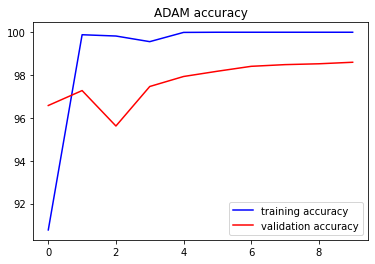

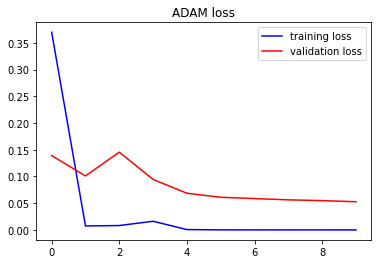

In [ ]:
# with
epoch = 10

plt.figure()
x=range(epoch)
plt.plot(x,train_logs["accuracy"],"b",label="training accuracy")
plt.plot(x,val_logs["accuracy"],"r",label="validation accuracy")
plt.title("ADAM accuracy")
plt.legend()
plt.show()


plt.figure()
x=range(epoch)
plt.plot(x,train_logs["loss"],"b",label="training loss")
plt.plot(x,val_logs["loss"],"r",label="validation loss")
plt.title("ADAM loss")
plt.legend()
plt.show()


In [ ]:
class_GTSRB = {'20_speed','30_speed','50_speed','60_speed','70_speed',
    '80_speed',
    '80_lifted',
    '100_speed',
    '120_speed',
    'no_overtaking_general',
    'no_overtaking_trucks',
    'right_of_way_crossing',
    'right_of_way_general',
    'give_way',
    'stop',
    'no_way_general',
    'no_way_trucks',
    'no_way_one_way',
    'attention_general',
    'attention_left_turn',
    'attention_right_turn',
    'attention_curvy',
    'attention_bumpers',
    'attention_slippery',
    'attention_bottleneck',
    'attention_construction',
    'attention_traffic_light',
    'attention_pedestrian',
    'attention_children',
    'attention_bikes',
    'attention_snowflake',
    'attention_deer',
    'lifted_general',
    'turn_right',
    'turn_left',
    'turn_straight',
    'turn_straight_right',
    'turn_straight_left',
    'turn_right_down',
    'turn_left_down',
    'turn_circle',
    'lifted_no_overtaking_general',
    'lifted_no_overtaking_trucks'}

In [ ]:
import cv2
model.eval()
img = Image.open('image1.jpg').convert('RGB')
img_trans = transform(img)
img_trans = img_trans.unsqueeze(0) 
input = img_trans.to(device)
prob = model(input)
print(prob)
pred=prob.data.max(1,keepdim=True)[1]
print(pred)
value, predicted = torch.max(prob.data, 1)
print(predicted.item())
print(value)
result = class_GTSRB[predicted.item()]
# pred_class = labels[predicted.item()]
# print(pred_class)
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title("Prediction value: {}".format(result))
plt.show()

tensor([[ -0.2895,  -6.6651, -14.7021, -10.0934, -10.6967,  -1.5091,  -5.7539,
         -10.8828,  -6.9689,  -8.0995,  -4.7310, -12.4235,  -7.3439, -10.6721,
          -9.6729, -10.0178,  -4.5467, -10.0861, -12.0420,  -9.0654, -10.0189,
         -10.9564, -12.3631,  -9.0453, -10.7231, -12.5309,  -9.3672, -12.5164,
          -8.6528, -10.2001, -14.8048,  -6.6275, -10.6889, -10.6877, -12.4082,
          -9.4473,  -9.1720, -11.5433,  -6.7894, -12.8001,  -7.6480, -12.2669,
          -7.7949]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0]], device='cuda:0')
0
tensor([-0.2895], device='cuda:0')


<ipython-input-8-41825f4bc847>:244: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y)


KeyError: ignored

In [ ]:
# without
optimizer = optimizer_ADAM
best_val_acc = 0
train_logs = {"loss" : [], "accuracy" : []}
val_logs = {"loss" : [], "accuracy" : []}
for epoch in range(10):
    loss, acc = OneEpoch(trainloader, 0, 0)
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(np.round(acc, 4)))
    
    loss, acc, best_val_acc = OneEpoch(testloader, best_val_acc, 1)    
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(np.round(acc, 4)))
  
print('Finished Training')

<ipython-input-6-41825f4bc847>:93: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y)


tensor(89.4970)

Training
Epoch 1
Loss : 0.4241
Acc : 89.49700164794922
tensor(94.7585)

Validating
Epoch 1
Loss : 0.1754
Acc : 94.75849914550781
tensor(99.9137)

Training
Epoch 2
Loss : 0.0081
Acc : 99.9136962890625
tensor(95.7799)

Validating
Epoch 2
Loss : 0.1447
Acc : 95.77989959716797
tensor(99.9775)

Training
Epoch 3
Loss : 0.0018
Acc : 99.97750091552734
tensor(96.6271)

Validating
Epoch 3
Loss : 0.1116
Acc : 96.6270980834961
tensor(100.)

Training
Epoch 4
Loss : 0.0004
Acc : 100.0
tensor(97.0071)

Validating
Epoch 4
Loss : 0.1014
Acc : 97.0071029663086
tensor(100.)

Training
Epoch 5
Loss : 0.0002
Acc : 100.0
tensor(97.0625)

Validating
Epoch 5
Loss : 0.1005
Acc : 97.0625
tensor(100.)

Training
Epoch 6
Loss : 0.0001
Acc : 100.0
tensor(97.2209)

Validating
Epoch 6
Loss : 0.0956
Acc : 97.22090148925781
tensor(100.)

Training
Epoch 7
Loss : 0.0001
Acc : 100.0
tensor(97.2447)

Validating
Epoch 7
Loss : 0.0936
Acc : 97.24459838867188
tensor(100.)

Training
Epoch 8
Loss : 0.0001
Acc : 

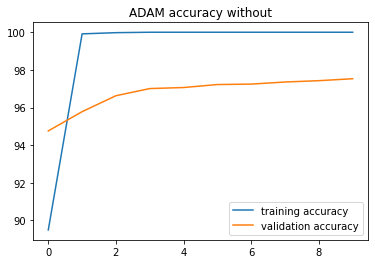

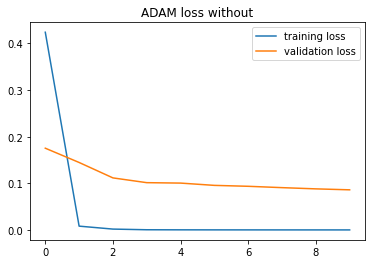

In [ ]:
# without
epoch = 10

plt.figure()
x=range(epoch)
plt.plot(x,train_logs["accuracy"],label="training accuracy")
plt.plot(x,val_logs["accuracy"],label="validation accuracy")
plt.title("ADAM accuracy without")
plt.legend()
plt.show()

plt.figure()
x=range(epoch)
plt.plot(x,train_logs["loss"],label="training loss")
plt.plot(x,val_logs["loss"],label="validation loss")
plt.title("ADAM loss without")
plt.legend()
plt.show()
